In [1]:
import glob, os, re, pickle
import pandas as pd
import numpy as np
from Paths import *
from OtherUsefulFunctions import *
from RegressionFunctions import *
import itertools
import matplotlib.pyplot as plt
import matplotlib

from scipy.constants import golden 
matplotlib.rcParams['figure.figsize'] = (golden * 10, 10)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fontsize1 = 22
matplotlib.rcParams.update({'font.size': fontsize1})

In [2]:
args = parse_args()
train_list, test_list, validation_list = load_lists(args, reCreate=False)

Loading data list from pickle files
#####################################################
Dataset Statistics
Train, test and validation lists :  2650 & 300 & 350
Train size [%] :  80.3
Validation size [%] :  9.1
Test size [%] :  10.6
Class  1  :  2296  Train  79.4  Val   9.1  Test  11.5
Class  3  :  1004  Train  82.3  Val   9.2  Test   8.6
#####################################################


In [3]:
list_tfrecord_train, fs_train = create_tfrecords_reg(train_list, args, name=str(1)+'train')
list_tfrecord_validation, fs_validation = create_tfrecords_reg(validation_list, args, name=str(1)+'validation')
list_tfrecord_test, fs_test = create_tfrecords_reg(test_list, args, name=str(1)+'test')
# If you set reCreate to True but do not have the original files from the list available  
# (samples only given in the github), the code will give a MatlabExecutionError

The 54 .tfrecord you are about to produce already exist, probably for the same list.
Re-run and change name if you do not want to overwrite them. If you do, set reCreate to True
The 6 .tfrecord you are about to produce already exist, probably for the same list.
Re-run and change name if you do not want to overwrite them. If you do, set reCreate to True
The 7 .tfrecord you are about to produce already exist, probably for the same list.
Re-run and change name if you do not want to overwrite them. If you do, set reCreate to True


In [4]:
train_dataset = input_pipeline(list_tfrecord_train[:-1], args)
validation_dataset = input_pipeline(list_tfrecord_validation, args)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [5]:
args.model_number=2

In [6]:
if os.path.exists(pathBase + '3_Regression/reg_model/model'+str(args.model_number)+'.pickle'):
    with open(pathBase + '3_Regression/reg_model/model'+str(args.model_number)+'.pickle', "rb") as f:
        loss, mae,Vloss, Vmae = pickle.load(f)
else:
    loss=[];mae=[]; Vloss=[]; Vmae=[];

In [7]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        loss.append(logs.get('loss'))
        mae.append(logs.get('custom_mae'))
        Vloss.append(logs.get('val_loss'))
        Vmae.append(logs.get('val_custom_mae'))
        with open(pathBase + '3_Regression/reg_model/model'+str(args.model_number)+'.pickle', "wb") as f:
            pickle.dump([loss, mae,Vloss, Vmae], f)

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

def custom_loss_wrapper(fweight):
    def custom_mae(y_true, y_pred):
        return K.mean(fweight*K.abs(y_true-y_pred), axis=-1)
    return custom_mae

In [9]:
model,fweight = ConvModelx()
if args.verbose: print("Using model") ;model.summary()
    
#if args.verbose: print('Continue training after loading weights of model', args.model_number)
model.load_weights(pathBase + '3_Regression/reg_model/'+str(args.model_number)+'all/ckp46').expect_partial()

model.compile(optimizer='adam',#Adam(lr=1e-3, decay=1e-3 / args.epochs),
              metrics = [custom_loss_wrapper(fweight)],
              loss='mean_absolute_error')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Using model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Spectrogram (InputLayer)        [(None, 600, 544, 1) 0                                            
__________________________________________________________________________________________________
Layer1.1 (Conv2D)               (None, 600, 544, 16) 160         Spectrogram[0][0]                
__________________________________________________________________________________________________
Layer1.2 (Conv2D)               (None, 600, 544, 16) 2320        Layer1.1[0][0]                   
__________________________________________________________________________________________________
Layer2 (AveragePooling2D)       (None, 300, 272, 16) 0         

In [30]:
if not args.skip_train:
    steps_per_epoch = int(len(list_tfrecord_train[:-1])*args.load_size/args.batch_size)
    validation_steps = int(len(list_tfrecord_validation)*args.load_size/args.batch_size)
    
    model.fit(x=train_dataset[0],y=train_dataset[1],
              epochs=args.epochs,steps_per_epoch=steps_per_epoch,
              validation_data=(validation_dataset[0],validation_dataset[1]), 
              validation_steps=validation_steps,
              callbacks=[myCallback(),es, 
                         ModelCheckpoint(pathBase + '3_Regression/reg_model/'+str(args.model_number)+'all/ckp'+"{epoch:02d}",
                                         monitor='loss', save_best_only=False, mode='min',
                                         save_weights_only=True)
                        ])

Epoch 1/100
53/53 [==============================] - 29s 546ms/step - loss: 0.1729 - custom_mae: 11.0928 - val_loss: 0.1286 - val_custom_mae: 8.1417
Epoch 2/100
53/53 [==============================] - 28s 537ms/step - loss: 0.1041 - custom_mae: 6.8208 - val_loss: 0.1022 - val_custom_mae: 6.7905
Epoch 3/100
53/53 [==============================] - 29s 540ms/step - loss: 0.0868 - custom_mae: 5.7166 - val_loss: 0.0937 - val_custom_mae: 6.2153
Epoch 4/100
53/53 [==============================] - 28s 536ms/step - loss: 0.0801 - custom_mae: 5.2309 - val_loss: 0.0859 - val_custom_mae: 5.7607
Epoch 5/100
53/53 [==============================] - 29s 543ms/step - loss: 0.0738 - custom_mae: 4.7932 - val_loss: 0.0783 - val_custom_mae: 5.1460
Epoch 6/100
53/53 [==============================] - 29s 538ms/step - loss: 0.0696 - custom_mae: 4.4746 - val_loss: 0.0757 - val_custom_mae: 4.9091
Epoch 7/100
53/53 [==============================] - 29s 539ms/step - loss: 0.0659 - custom_mae: 4.2120 - val_l

53/53 [==============================] - 29s 540ms/step - loss: 0.0285 - custom_mae: 1.7920 - val_loss: 0.0360 - val_custom_mae: 2.1493
Epoch 57/100
53/53 [==============================] - 28s 536ms/step - loss: 0.0291 - custom_mae: 1.8220 - val_loss: 0.0369 - val_custom_mae: 2.2361
Epoch 58/100
53/53 [==============================] - 29s 539ms/step - loss: 0.0283 - custom_mae: 1.7658 - val_loss: 0.0353 - val_custom_mae: 2.1440
Epoch 59/100
53/53 [==============================] - 28s 535ms/step - loss: 0.0274 - custom_mae: 1.7138 - val_loss: 0.0398 - val_custom_mae: 2.4052
Epoch 60/100
53/53 [==============================] - 29s 542ms/step - loss: 0.0263 - custom_mae: 1.6330 - val_loss: 0.0377 - val_custom_mae: 2.2897
Epoch 61/100
53/53 [==============================] - 29s 539ms/step - loss: 0.0274 - custom_mae: 1.7186 - val_loss: 0.0359 - val_custom_mae: 2.1545
Epoch 62/100
11/53 [=====>........................] - ETA: 21s - loss: 0.0250 - custom_mae: 1.4782

KeyboardInterrupt: 

# Results test

In [10]:
test_dataset = tf.data.TFRecordDataset(list_tfrecord_test)
test_dataset = test_dataset.map(parse_example_reg).repeat().batch(args.batch_size)
iterator = test_dataset.make_one_shot_iterator()
test_dataset= iterator.get_next()

test_steps = int(len(list_tfrecord_test*args.load_size)/args.batch_size)

score = model.evaluate(x=test_dataset[0],y=test_dataset[1], 
                       verbose=args.verbose, steps=test_steps)

prediction = model.predict(test_dataset[0],steps=test_steps)

7/7 [==============================] - 4s 545ms/step - loss: 0.0302 - custom_mae: 1.8669


# Figures Train

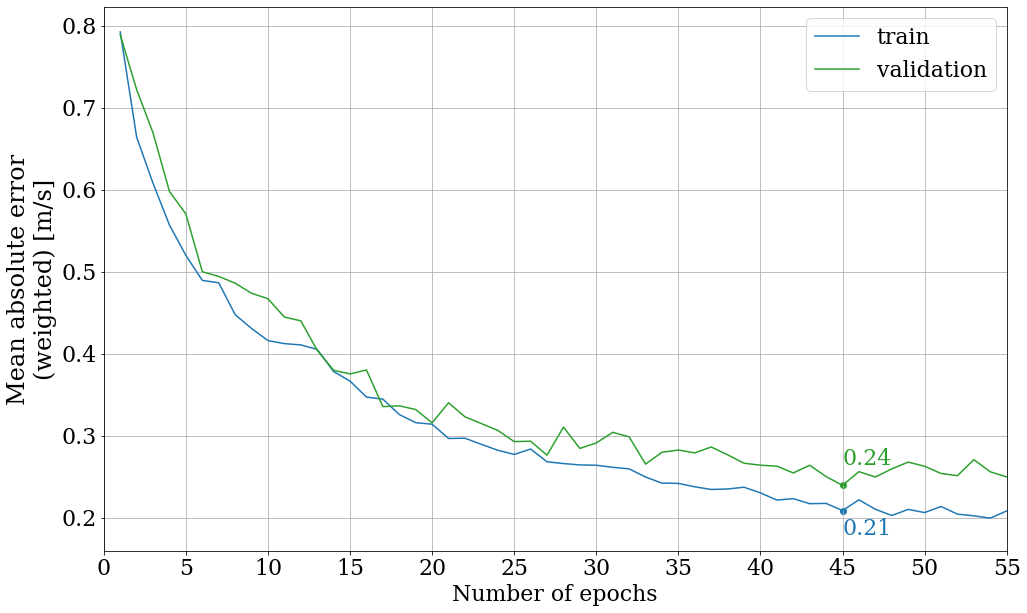

In [11]:
fig, ax = plt.subplots();
index = 45

ax.plot(np.arange(1,len(mae),1),np.abs(f2vRadar(np.array(mae[1:]))),color='tab:blue',label='train')
ax.plot(np.arange(1,len(mae),1),np.abs(f2vRadar(np.array(Vmae[1:]))),color='tab:green',label='validation');
ax.set_ylabel('Mean absolute error\n(weighted) [m/s]', fontsize=fontsize1+2);
ax.legend(fontsize=fontsize1);
ax.grid();
ax.set_xlabel('Number of epochs');
ax.set_xlim(0,55);

ax.set_xticks(np.arange(0,56,5))

y1 = np.abs(f2vRadar(mae[index]));
y2 = np.abs(f2vRadar(Vmae[index]));
ax.text(index,y1-0.03,s=str(round(np.abs(f2vRadar(mae[index])),2)),color='tab:blue');
ax.scatter(index,y1,color='tab:blue');
ax.text(index,y2+0.025,s=str(round(np.abs(f2vRadar(Vmae[index])),2)),color='tab:green');
ax.scatter(index,y2,color='tab:green');

# 46 loss: 0.0290 - custom_mae: 1.7960 - val_loss: 0.0332 - val_custom_mae: 2.0609
#####loss: 0.0302 - custom_mae: 1.8669


plt.savefig(pathSave+'reg/'+'fig1', bbox_inches='tight')

# Figures Test

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

cmap=matplotlib.colors.ListedColormap(['tab:blue','tab:red'])
bounds = [0,2,4]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

In [13]:
fss = np.array(list(itertools.chain(*fs_test)))
fmax = []
for k in np.array(list(itertools.chain(*fs_test))):
    temp=getFspec(k)
    fmax.append(temp)
labels_testV = [k[4] for k in test_list]
x = [k[5] for k in test_list]
predictionV = prediction.reshape(len(prediction))*fmax

y = f2vRadar(predictionV)
x = f2vRadar(np.array(x))

lin = LinearRegression().fit(x.reshape(-1, 1),y.reshape(-1, 1))

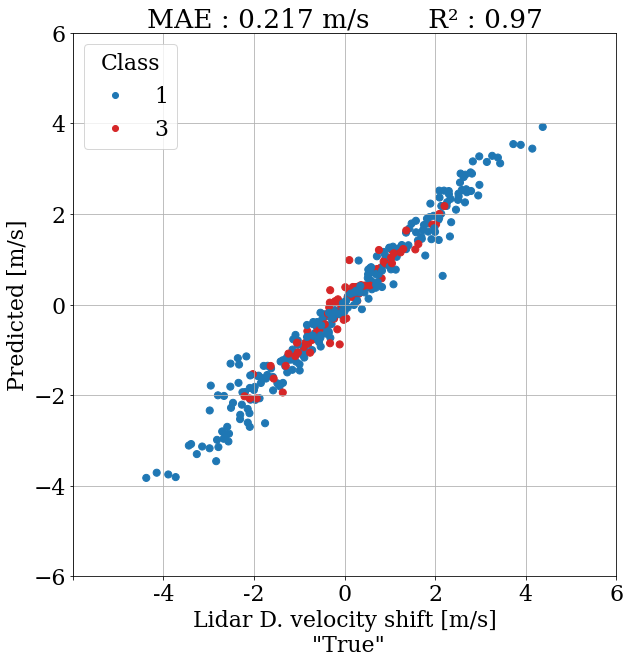

In [14]:
fig, ax = plt.subplots()

sc = ax.scatter(x, y, c=np.abs(labels_testV),s=50, vmin=0, vmax=7, cmap=cmap,norm=norm);

plt.gca().set_aspect('equal')
ax.set_xlabel('Lidar D. velocity shift [m/s]\n "True"')
ax.set_ylabel('Predicted [m/s]')

legend1 = ax.legend(*sc.legend_elements(),loc='upper left', title='Class')

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.grid()  
ax.set_yticks(np.arange(-6,7,2));
ax.set_xticks(np.arange(-6,7,2));ax.set_xticklabels(['', -4,-2,0,2,4,6]);

ax.set_title('MAE : ' + str(round(mean_absolute_error(y,x),3)) +' m/s'+
            '       R\u00b2 : '+str(round(lin.score(x.reshape(-1, 1),y.reshape(-1, 1)),2)));

plt.savefig(pathSave+'reg/'+'fig2', bbox_inches='tight')

In [15]:
x3 = x[np.where(np.abs(labels_testV)==3)]
y3 = y[np.where(np.abs(labels_testV)==3)]
x1 = x[np.where(np.abs(labels_testV)==1)]
y1 = y[np.where(np.abs(labels_testV)==1)]

print(round(mean_absolute_error(x1,y1),3),round(mean_absolute_error(x3,y3),3))
x3 = x[np.where((np.abs(labels_testV)==3) & (np.abs(x)<2))]
y3 = y[np.where((np.abs(labels_testV)==3) & (np.abs(x)<2))]
x1 = x[np.where((np.abs(labels_testV)==1) & (np.abs(x)<2))]
y1 = y[np.where((np.abs(labels_testV)==1) & (np.abs(x)<2))]

print(round(mean_absolute_error(x1,y1),3),round(mean_absolute_error(x3,y3),3))

0.232 0.171
0.176 0.17


# Dataset

In [16]:
fontsize1 = 32
matplotlib.rcParams.update({'font.size': fontsize1})

import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.getcwd()+'/MatlabFunctions/',nargout=0)

xx = np.arange(0,350,1)
np.random.shuffle(xx)
predictionV = prediction.reshape(len(prediction))*fmax

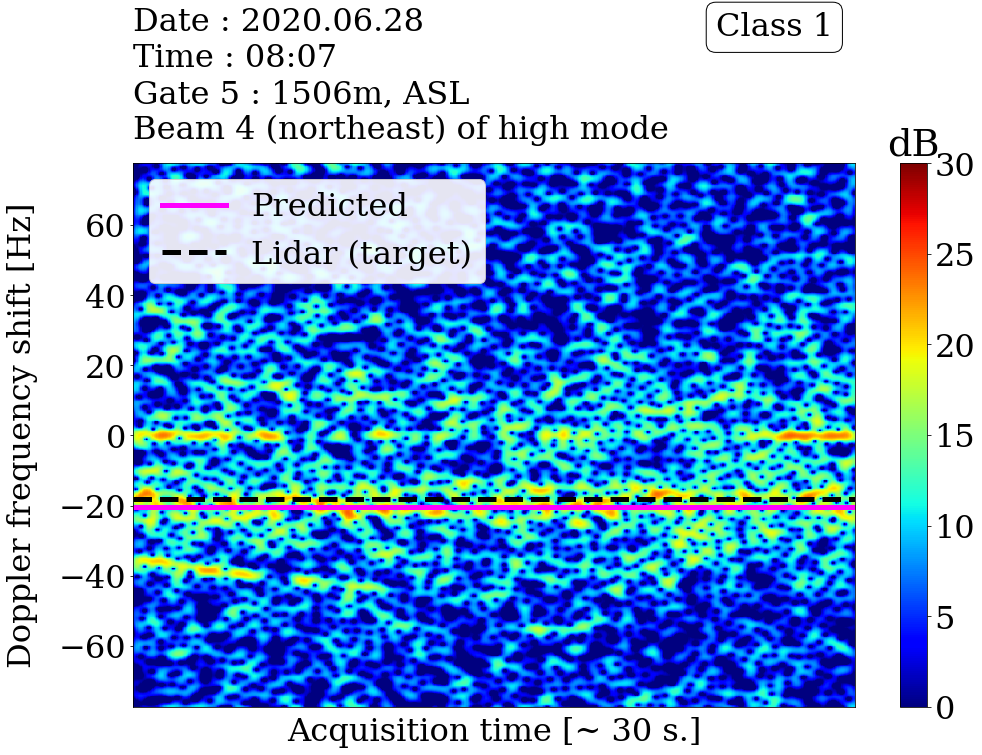

In [17]:
for indice, k in enumerate(test_list):
        
    out = eng.loadSpecReg(k[3],k[2],k[0]+1, nargout=4)
    fig, ax = plt.subplots();
    
    if k[4] >= 0:
        spec =  np.array(out[0])
    if k[4] < 0:
        spec = np.flip(np.array(out[0]),axis=0)
        k[4]=k[4]*-1
        
    date = re.search(path_dat+'(.*).dat',k[3]).group(1).split('.DAT/')  

    ax.annotate('Date : '+titleChosenDate(date[0]) + ' \nTime : '+k[1][0:2]+':'+k[1][2:4]+
                 '\nGate '+ str(k[0])+ ' : ' + str(high_mode[k[0]]) + 'm, ASL'+
                 '\n'+ beam_radar_pretty[str(k[2])],
                xy=(0, 700), xycoords='axes points', 
                size=fontsize1, ha='left', va='top')

    ax.annotate('Class '+str(int(k[4])),
            xy=(700, 695), xycoords='axes points', 
            size=fontsize1, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))

    im1=ax.pcolormesh(np.arange(0,544,1),np.array(out[3]),spec ,cmap='jet', vmin=0, vmax=30);

    ax.axhline(predictionV[indice], color='fuchsia',linestyle='solid',linewidth=5, label='Predicted')
    ax.axhline(k[5], color='black',linestyle='dashed',linewidth=5, label='Lidar (target)')
    ax.legend(loc='upper left',framealpha=0.9)
           

    cbar1 = fig.colorbar(im1)
    cbar1.ax.set_title('dB')
    ax.set_ylabel('Doppler frequency shift [Hz]')
    ax.set_xlabel('Acquisition time [~ 30 s.]')
    plt.setp(ax.get_xticklabels(), visible=False);
    ax.tick_params(axis='x', which='both',bottom=False, top=False)
    ax.yaxis.labelpad=20
    ax.xaxis.labelpad=10

    plt.savefig(pathSave+'reg/test/test'+str(xx[indice]), bbox_inches='tight')
    plt.close()
    print(indice)


# Histograms velocity and fmax

In [18]:
train_list1 = train_list[:2650]
Vtrain = np.array([k[5] for k in train_list1])
Vval = np.array([k[5] for k in validation_list])
Vtest = np.array([k[5] for k in test_list])

labels_train = [int(k[4]) for k in train_list1]
labels_validation = [int(k[4]) for k in validation_list]
labels_test = [int(k[4]) for k in test_list]


def binned(variable,labels):
    b=variable.copy(); d=variable.copy()
    b[np.array(labels)!=1]=np.nan
    d[np.array(labels)!=3]=np.nan
    x=np.vstack((b,d)).T    
    return x

fs_train=fs_train[:-1]
fs_train = np.array(list(itertools.chain(*fs_train)))
fs_test = np.array(list(itertools.chain(*fs_test)))
fs_validation = np.array(list(itertools.chain(*fs_validation)))

fmax_train = np.array([getFspec(k) for k in fs_train])
fmax_test = np.array([getFspec(k) for k in fs_test])
fmax_validation = np.array([getFspec(k) for k in fs_validation])

allFmax = np.unique(np.hstack((np.unique(fmax_train),np.unique(fmax_validation),np.unique(fmax_test))))

allFmaxticks = [ 51.75983437,  60.53268765,  70.0280112 , 79.36507937,
        87.10801394,  96.52509653,105.04201681,114.20737327, 123.15270936]
allFmaxLab = [52,61,70,79,89,97,105,115,123]

def binned2(variable,labels,allFmax=allFmax):
    a1=variable.copy(); a2=variable.copy()
    a1[np.array(labels)!=1]=np.nan
    a2[np.array(labels)!=3]=np.nan 
    count1=[];count2=[]
    for f in allFmax:
        count1.append(np.count_nonzero(a1[~np.isnan(a1)]==f))
        count2.append(np.count_nonzero(a2[~np.isnan(a2)]==f))  
    return count1, count2

In [19]:
matplotlib.rcParams['figure.subplot.hspace'] = 0.5
matplotlib.rcParams['figure.subplot.wspace'] = 0.25
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['ytick.labelsize'] = 'small'
fontsize1 = 22-2
matplotlib.rcParams.update({'font.size': fontsize1})

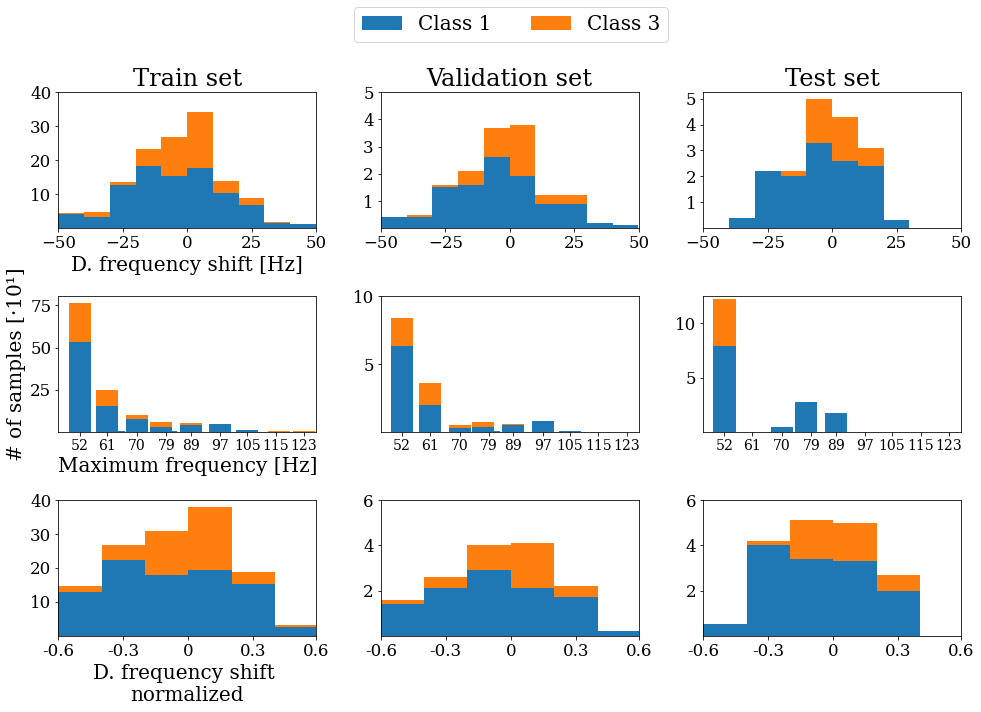

In [20]:
fig, ax = plt.subplots(3,3);

hist,bins=np.histogram(Vtrain,bins=10)
bins = np.arange(-50,50,9.99)

x = binned(Vtrain,labels=labels_train)
ax[0,0].hist(x, bins=bins,stacked=True,label=['Class 1','Class 3']);
ax[0,0].set_title('Train set');
#ax[0,0].set_ylabel('# of samples [·10¹]');
ax[0,0].set_xlabel('D. frequency shift [Hz]');
x = binned(Vval,labels=labels_validation)
ax[0,1].hist(x, bins=bins,stacked=True);
ax[0,1].set_title('Validation set');
x = binned(Vtest,labels=labels_test)
ax[0,2].hist(x, bins=bins,stacked=True);
ax[0,2].set_title('Test set');
ax[0,0].set_xlim(-50,50);ax[0,1].set_xlim(-50,50);ax[0,2].set_xlim(-50,50);
ax[0,0].set_yticks([100,200,300,400]);ax[0,1].set_yticks([10,20,30,40,50]);ax[0,2].set_yticks([10,20,30,40,50]);
ax[0,0].set_yticklabels([10,20,30,40]);
ax[0,1].set_yticklabels([1,2,3,4,5]);
ax[0,2].set_yticklabels([1,2,3,4,5]);
ax[0,0].set_xticks(np.arange(-50,51,25));
ax[0,1].set_xticks(np.arange(-50,51,25));
ax[0,2].set_xticks(np.arange(-50,51,25));


width=7
count1, count2 = binned2(fmax_train,labels_train)
ax[1,0].bar(allFmax, count1,color='tab:blue',width=width);
ax[1,0].bar(allFmax,count2,bottom=count1,color='tab:orange',width=width);
ax[1,0].set_ylabel('# of samples [·10¹]');
ax[1,0].set_xlabel('Maximum frequency [Hz]');
count1, count2 = binned2(fmax_validation,labels_validation)
ax[1,1].bar(allFmax, count1,color='tab:blue',width=width);
ax[1,1].bar(allFmax,count2,bottom=count1,color='tab:orange',width=width);
count1, count2 = binned2(fmax_test,labels_test)
ax[1,2].bar(allFmax, count1,color='tab:blue',width=width);
ax[1,2].bar(allFmax,count2,bottom=count1,color='tab:orange',width=width);

ax[1,0].set_yticks([250,500,750]);
ax[1,1].set_yticks([50,100]);
ax[1,2].set_yticks([50,100]);ax[1,2].set_ylim(0,125)
ax[1,0].set_yticklabels([25,50,75]);
ax[1,1].set_yticklabels([5,10]);
ax[1,2].set_yticklabels([5,10]);
ax[1,0].set_xlim(45,127)
ax[1,1].set_xlim(45,127)
ax[1,2].set_xlim(45,127)

ax[1,0].set_xticks(allFmaxticks);
ax[1,1].set_xticks(allFmaxticks);
ax[1,2].set_xticks(allFmaxticks);
ax[1,0].set_xticklabels(allFmaxLab,fontsize=14);
ax[1,1].set_xticklabels(allFmaxLab,fontsize=14);
ax[1,2].set_xticklabels(allFmaxLab,fontsize=14);

bins = np.arange(-0.60,0.61,0.2)
x = binned(Vtrain/fmax_train,labels=labels_train)
ax[2,0].hist(x, bins=bins,stacked=True);
ax[2,0].set_xlabel('D. frequency shift \nnormalized');
x = binned(Vval/fmax_validation,labels=labels_validation)
ax[2,1].hist(x, bins=bins,stacked=True);
x = binned(Vtest/fmax_test,labels=labels_test)
ax[2,2].hist(x, bins=bins,stacked=True);
ax[2,0].set_xlim(-0.60,0.59);
ax[2,1].set_xlim(-0.60,0.59);
ax[2,2].set_xlim(-0.60,0.59);
ax[2,0].set_xticks([-0.6,-0.3,0,0.3,0.59]);
ax[2,1].set_xticks([-0.6,-0.3,0,0.3,0.59]);
ax[2,2].set_xticks([-0.6,-0.3,0,0.3,0.59]);
ax[2,0].set_xticklabels([-0.6,-0.3,0,0.3,'0.6']);
ax[2,1].set_xticklabels([-0.6,-0.3,0,0.3,'0.6']);
ax[2,2].set_xticklabels([-0.6,-0.3,0,0.3,'0.6']);

ax[2,0].set_yticks([100,200,300,400]);
ax[2,1].set_yticks([20,40,60]);ax[2,1].set_ylim(0,60)
ax[2,2].set_yticks([20,40,60]);ax[2,2].set_ylim(0,60)
ax[2,0].set_yticklabels([10,20,30,40]);
ax[2,1].set_yticklabels([2,4,6]);
ax[2,2].set_yticklabels([2,4,6]);

ax[0,0].legend(ncol=2,loc='upper center',bbox_to_anchor=(1.17,0.85,1.17,0.85));
plt.savefig(pathSave+'reg/'+'fig3', bbox_inches='tight')